In [1]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

2021-09-02 15:50:22.060291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-02 15:50:22.060325: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
!pwd

/home/timjab92/code/timjab92/cryptotrading-indicator/notebooks


In [3]:
!pwd

/home/timjab92/code/timjab92/cryptotrading-indicator/notebooks


In [4]:
from tensorflow.keras.models import load_model
model = load_model("../../models/new_data_high_bollinger_up_rsi_1_71")

2021-09-02 15:50:24.472659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-02 15:50:24.472697: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-02 15:50:24.472709: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-33CGF2OU): /proc/driver/nvidia/version does not exist
2021-09-02 15:50:24.472904: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
CLOSE = 'close'
SELECTED_FEATURES = [CLOSE,'high','bollinger_up','rsi']
WINDOW_SIZE = 18
HORIZON = 1

In [6]:
import requests
def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api


def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data[CLOSE])
    add_vol_roc(data)
    return data

## add other features

def add_ema(data, tspan=[12,26,20,50,34,55,21,99,200]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data[CLOSE].ewm(span=t).mean()
        data[f'dist_ema{t}'] = data[CLOSE] - data[f'ema{t}']
    return data


def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data[CLOSE], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data


def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down


def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    for i in ['bollinger_up', 'bollinger_down']:
        data[f'dist_{i}'] = data[CLOSE] - data[i]
    return data


def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data


In [47]:
def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011.
    The index is set to the date.
    """
    data = pd.read_csv("../data/BTC4h.csv")
    data['date'] = pd.to_datetime(data.date)
    #data_train = data.drop(columns="Unnamed: 0").set_index("date")
    return data_train.set_index("date")


def minmaxscaling(data_train):
    """
    applies the minmaxscaler to the training set. Attention! Output needs to be
    defined for data_train_scaled, min1 and range1!!
    """
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    minmax_scaler.fit(data_train)
    data_train_scaled = minmax_scaler.transform(data_train)
    min1 = minmax_scaler.data_min_[0]  # [5:9] for log_prices
    range1 = minmax_scaler.data_range_[0]  #[5:9]
    return data_train_scaled, minmax_scaler, min1, range1


def get_xgecko(winsize=18, horizon=1):
    """
    Calls the coingecko API and returns the data used for prediction.
    x_gecko.shape == (no_sequ , winsize, no_features)
    """
    x_gecko = feature_engineer(get_coingecko())[SELECTED_FEATURES][-winsize:]
    #get scaler the long way
    data_train = feature_engineer(get_new_data())[SELECTED_FEATURES]
    data_train_scaled, scaler,min1,range1 = minmaxscaling(data_train)

    x_gecko_scaled = scaler.transform(x_gecko)
    x_gecko = np.array(x_gecko_scaled[-winsize:])
    x_gecko = np.reshape(x_gecko, (-1, winsize, len(SELECTED_FEATURES)))
    return x_gecko


def get_xy(data_train_scaled, window_size=WINDOW_SIZE, horizon=HORIZON):
    data_train_subsequences = []
    fake_y_train = []
    for k in range(len(data_train_scaled)-(window_size-1)-horizon):
        data_train_subsequences.append(data_train_scaled[k:k+window_size])
        fake_y_train.append(data_train_scaled[k+window_size:k+window_size+horizon])

    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(data_train_subsequences), np.array(
        fake_y_train)[:, :, 0]

    return x_train, y_train

In [48]:
def get_new_data():
    data = pd.read_csv("../data/BTC4h.csv")
    data['date'] = pd.to_datetime(data.date)
    data = data.set_index('date')
    return data

data = get_new_data()

In [49]:
data = feature_engineer(get_new_data()).dropna()

In [50]:
selected_data = data[SELECTED_FEATURES]

In [51]:
data.shape

(12775, 36)

In [52]:
train_percentage = 95
train_len = int(len(selected_data) * train_percentage/100)
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]

In [53]:
data_train.shape

(12136, 4)

In [54]:
data_train_scaled, scaler, min1, range1 = minmaxscaling(data_train)

In [55]:
data_test_scaled = scaler.transform(data_test)

In [56]:
x_test, y_test = get_xy(data_test_scaled)

In [57]:
data_train.shape

(12136, 4)

In [58]:
pred = model.predict(x_test)
predictions_unscaled = pred * range1 + min1
y_test_unscaled = y_test * range1 + min1

In [59]:
pred = pd.DataFrame(predictions_unscaled, columns = ['pred_1']) #,'pred_2','pred_3''pred_4','pred_5','pred_6'
test = pd.DataFrame(y_test_unscaled, columns = ['test_1']) # ,'test_2','test_3'#, 'test_4','test_5','test_6'
result = pd.concat([pred, test], axis=1)

In [60]:
for i in range(1,2):
    result[f'weight_{i}'] = np.mean(result[f'test_{i}'] - result[f'pred_{i}'])
    result[f'pred_weight_{i}'] = result[f'pred_{i}'] + result[f'weight_{i}']

In [61]:
result

,pred_1,test_1,weight_1,pred_weight_1
0,57717.355469,57427.04,-83.862511,57633.492958
1,57220.078125,57849.03,-83.862511,57136.215614
2,57415.027344,57869.40,-83.862511,57331.164833
3,57590.484375,56547.40,-83.862511,57506.621864
4,56393.906250,56692.50,-83.862511,56310.043739
...,...,...,...,...
616,45847.011719,45289.65,-83.862511,45763.149208
617,45309.761719,44758.93,-83.862511,45225.899208
618,44671.066406,44204.11,-83.862511,44587.203895
619,43983.058594,44407.09,-83.862511,43899.196083


In [62]:
mae = np.mean(np.abs(y_test_unscaled[:,0] - predictions_unscaled[:,0]))
mae

669.971510542472

In [63]:
mape = np.mean(np.abs((y_test_unscaled - predictions_unscaled) / y_test_unscaled)) *100
mape

1.708367968757586

In [64]:
result

,pred_1,test_1,weight_1,pred_weight_1
0,57717.355469,57427.04,-83.862511,57633.492958
1,57220.078125,57849.03,-83.862511,57136.215614
2,57415.027344,57869.40,-83.862511,57331.164833
3,57590.484375,56547.40,-83.862511,57506.621864
4,56393.906250,56692.50,-83.862511,56310.043739
...,...,...,...,...
616,45847.011719,45289.65,-83.862511,45763.149208
617,45309.761719,44758.93,-83.862511,45225.899208
618,44671.066406,44204.11,-83.862511,44587.203895
619,43983.058594,44407.09,-83.862511,43899.196083


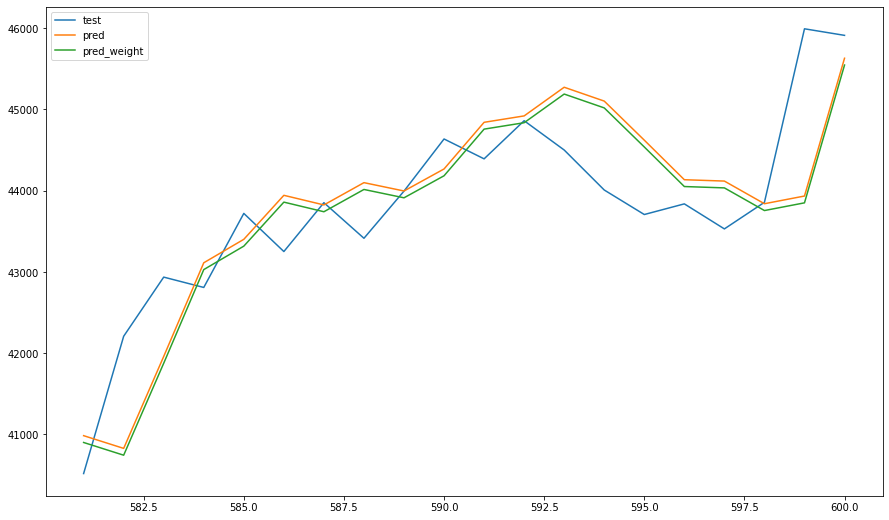

In [78]:
plt.figure(figsize=(15,9))
plt.plot(result[['test_1', 'pred_1', 'pred_weight_1']][-40:-20], label=["test", "pred", "pred_weight"])
plt.legend()                                      #timehorizon here
plt.show()

# coingecko prediction

In [66]:
coingecko = get_coingecko()

In [67]:
feature_engineer(coingecko.copy())

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,dist_ema200,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc
2021-08-03 16:00:00,38638.23,38638.23,38402.57,38402.57,2.882061e+10,10.561997,10.561997,10.555880,10.555880,38402.570000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-03 20:00:00,38205.20,38554.67,38154.24,38165.01,2.851683e+10,10.550727,10.559833,10.549392,10.549674,38273.891667,...,-118.186100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010540
2021-08-04 00:00:00,38128.75,38419.85,38082.36,38406.36,2.797357e+10,10.548724,10.556330,10.547506,10.555978,38325.594088,...,81.698040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.019050
2021-08-04 04:00:00,38175.78,38496.08,38175.78,38187.73,2.657571e+10,10.549957,10.558312,10.549957,10.550270,38282.075783,...,-102.183772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.049971
2021-08-04 08:00:00,38021.40,38175.25,38021.40,38162.26,2.585648e+10,10.545904,10.549943,10.545904,10.549602,38249.522263,...,-101.609863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01 20:00:00,47534.39,48849.86,47534.39,48751.95,3.950387e+10,10.769209,10.796507,10.769209,10.794500,47715.958108,...,1645.854409,58.758793,70.111459,52.969139,47857.7120,49164.052238,46551.371762,-412.102238,2200.578238,0.013708
2021-09-02 00:00:00,48233.38,48427.57,48233.38,48427.57,3.922771e+10,10.783807,10.787825,10.783807,10.787825,47825.436860,...,1305.625931,55.118289,76.721354,66.333470,47856.2845,49159.931056,46552.637944,-732.361056,1874.932056,-0.006991
2021-09-02 04:00:00,48823.06,49734.07,48741.84,49638.76,3.949302e+10,10.795958,10.814445,10.794293,10.812527,48104.409651,...,2486.693224,64.069714,94.139972,80.324262,47898.8940,49374.882485,46422.905515,263.877515,3215.854485,0.006763
2021-09-02 08:00:00,49573.82,49847.11,49392.44,49847.11,4.030017e+10,10.811218,10.816716,10.807553,10.816716,48372.517397,...,2662.852362,65.349958,94.139972,88.333766,47937.5110,49574.652945,46300.369055,272.457055,3546.740945,0.020438


In [68]:
x_gecko = get_xgecko()

In [70]:
x_gecko.shape

(1, 18, 4)

In [71]:
# data_train_scaled, scaler, min1, range1 = minmaxscaling(feature_engineer(get_train_data())[[CLOSE]])

In [72]:
x_gecko

array([[[0.74042285, 0.73803862, 0.74494777, 0.4196897 ],
        [0.7515469 , 0.74767912, 0.74299756, 0.52020007],
        [0.73736612, 0.74901139, 0.74427708, 0.41681323],
        [0.72816188, 0.72507362, 0.74707074, 0.36376192],
        [0.72837378, 0.72765589, 0.74786376, 0.36566389],
        [0.73559694, 0.73636871, 0.74725964, 0.42900694],
        [0.73338267, 0.738038  , 0.74643352, 0.41461143],
        [0.73262587, 0.73046071, 0.74561901, 0.40952052],
        [0.73022706, 0.72869012, 0.74554676, 0.39292339],
        [0.72629352, 0.72833965, 0.74472488, 0.36626795],
        [0.73327478, 0.73106003, 0.7433914 , 0.43598694],
        [0.73604001, 0.73391776, 0.74172934, 0.46167692],
        [0.73314885, 0.73525854, 0.74069433, 0.43845198],
        [0.75412931, 0.75176255, 0.7408736 , 0.5988178 ],
        [0.74908638, 0.74523125, 0.74081118, 0.55749478],
        [0.767916  , 0.76543807, 0.74406684, 0.65910158],
        [0.77115509, 0.76718639, 0.74709256, 0.6736335 ],
        [0.774

In [73]:
x_gecko_pred = model.predict(x_gecko)

In [41]:
#pred = np.exp(scaler.inverse_transform(pred))

In [74]:
x_gecko_unscaled = x_gecko_pred * range1 + min1
x_gecko_unscaled

array([[50290.555]], dtype=float32)

In [43]:
#pred = scaler.inverse_transform(pred)

In [ ]:
#pred[0][0]

In [ ]:
#df = coingecko[[CLOSE]].reset_index(drop=True) #.apply(lambda x: np.exp(x))

In [ ]:
#df1 = pd.DataFrame(pred_gecko_unscaled.reshape(4,1),columns=[CLOSE]).apply(lambda x: np.exp(x))

In [ ]:
# df2 = pd.concat([df,df1],axis=0).reset_index(drop=True)
# df2

In [ ]:
coingecko = feature_engineer(get_coingecko())

In [ ]:
coingecko[-20:]

In [ ]:
go.Candlestick(
            x=df.index,  #x=filtered_data.index,
            open=df['open'],  #open=filtered_data['open'],
            high=df['high'],  #high=filtered_data['high'],
            low=df['low'],  #low=filtered_data['low'],
            close=df['close'],  #close=filtered_data['close']
            name=''
        )

In [ ]:
last_date = coingecko.index[-1]

In [ ]:
last_date + pd.Timedelta()

In [ ]:
random_val = [80000]

In [ ]:
df_pred = pd.DataFrame(random_val, columns=['close'])

In [ ]:
df_pred

In [ ]:
coingecko.append(pd.Series(random_val))

# Whats going on?!?

In [ ]:
data = feature_engineer(get_train_data())
data.dropna(inplace=True)
data = data.iloc[1: , :]

In [ ]:
data.drop(columns=['open','high','low','close'], inplace = True)

In [ ]:
data

In [ ]:
data['boll_width'] = data['bollinger_up'] - data['bollinger_down']

In [ ]:
data

In [ ]:
import seaborn as sns

In [ ]:
df1 = data[['log_close', 'vol_roc', 'ema12','ema26','ema20','ema50','ema34','ema55', 'bollinger_up','bollinger_down']].corr()

In [ ]:
sns.heatmap(df1.corr())

In [ ]:
data.keys()

In [ ]:
df2 = data[['log_close','vol_roc',
       'dist_ema12', 'dist_ema26', 'dist_ema20',
       'dist_ema50', 'dist_ema34', 'dist_ema55', 'dist_bollinger_up',
       'dist_bollinger_down']]

In [ ]:
sns.heatmap(df2.corr())

In [ ]:
data.keys()

In [ ]:
sns.heatmap(data[['log_close', 'ema21', 'dist_ema21', 'ema99', 'dist_ema99']].corr())

In [ ]:
df = pd.DataFrame(data[['log_close','vol_roc']])

In [ ]:
# for i in [12, 26, 20, 50, 34, 55]:
#     df[f'dist_ema{i}'] = data['log_close'] - data[f'ema{i}']

In [ ]:
# for i in ['bollinger_up', 'bollinger_down']:
#     df[f'dist_{i}'] = data['log_close'] - data[i]

In [ ]:
df.corr()

In [ ]:
def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data.log_close)
    add_vol_roc(data)
    return data

In [ ]:
df.keys()

In [ ]:
data[['log_close', 'vol_roc', 'ema12','ema26','ema20','ema50','ema34','ema55', 'bollinger_up','bollinger_down']].corr()

# redefining get_xy

In [ ]:
LENGTH = 60
HORIZON = 1
SELECTED_FEATURES=['log_price']

In [ ]:
def get_xy(data_train_scaled, length=LENGTH, horizon=HORIZON):
    y_train = []
    x_train = [
        data_train_scaled[i - length:i, 0] for i in range(length, len(data_train_scaled))
        ]
    y_train = [
        data_train_scaled[i, 0] for i in range(length, len(data_train_scaled))
    ]

    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(SELECTED_FEATURES)))
    return x_train, y_train

In [ ]:
data_train_scaled, scaler = minmaxscaling(feature_engineer(get_train_data())[['log_close']])

In [ ]:
x1,y1= get_xy(data_train_scaled, 60,1)

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
y

In [ ]:
def get_xy_alt(data_train_scaled, window_size=60, horizon=1):
    data_train_subsequences = []
    fake_y_train = []
    for k in range(len(data_train_scaled)-(window_size-1)-horizon):
        data_train_subsequences.append(data_train_scaled[k:k+window_size])
        fake_y_train.append(data_train_scaled[k+window_size]) #add [0] for log_price to be predicted
    
    X_train = np.array(data_train_subsequences)
    y_train = np.array(fake_y_train)[:,0].reshape(-1,1)
    return X_train, y_train

In [ ]:
x2,y2 = get_xy_alt(data_train_scaled,60,1)

In [ ]:
y2.shape

In [ ]:
y1

In [ ]:
y2

In [ ]:
coingecko = feature_engineer(get_coingecko())
coingecko['gradient'] = coingecko['close'].diff()

In [ ]:
coingecko.keys()

In [ ]:
plt.plot(coingecko['gradient'])

In [ ]:
coingecko.corr()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(coingecko['log_close'], coingecko['ema99'])